In [1]:
from collections import Counter, defaultdict, deque
from functools import partial, lru_cache
from itertools import chain, cycle, product

import numpy as np

In [2]:
recipes = [
    {"A": 11, "B": 15, "C": 18, "D": 4, "E": 9, "F": 8},
    {"A": 16, "B": 10, "C": 8, "D": 4, "E": 4, "F": 8},
    {"A": 10, "B": 15, "C": 5, "D": 8},
    {"A": 10, "B": 12},
]
batch_sizes = [25, 50, 100]
sample_size = 20000
lane_lock = 25

In [3]:
def generate_batches_weighted(batch_size, recipe, sample_size):
    products = list(recipe.keys())
    totals = list(recipe.values())
    sizes = (np.ceil(np.array(totals) / np.min(totals)) * batch_size).astype(int).tolist()
    iterators = [[product]*size for product, size in zip(products, sizes)]
    base = cycle(chain(*iterators))
    return list(dict(zip(range(sample_size), base)).values())

In [4]:
def generate_random_weighted(recipe, sample_size):
    products = list(recipe.keys())
    return np.random.choice(
        products,
        size=sample_size,
        p=[t / sum(recipe.values()) for t in recipe.values()],
    ).tolist()

In [5]:
# # consider lane with lowest index (index := lane number)
# def no_priority(lane_tuple, product=None):
    
#     if product is None:
#         raise RuntimeError("No product set")
    
#     return lane_tuple[0]

# # consider lane with largest total number of products
def sum_of_product_priority(lane_tuple, product=None, boxes=None):
    
    if product is None:
        raise RuntimeError("No product set")
    
    return (sum(lane_tuple[1].values()), -boxes[lane_tuple[0]])

# # consider lane with largest product count e.g., largest number of As
# def product_count_priority(lane_tuple, product=None):
    
#     if product is None:
#         raise RuntimeError("No product set")
    
#     return lane_tuple[1][product]

# # consider largest product count first, then largest sum of all products second
# def double_priority(lane_tuple, product=None):
    
#     if product is None:
#         raise RuntimeError("No product set")
    
#     return (lane_tuple[1][product], sum(lane_tuple[1].values()))


# lane priority
def product_count_lane_utilization_priority(lane_tuple, product=None, boxes=None):
    
    if product is None or boxes is None:
        raise RuntimeError("Please provide product and lane state")
    
    # negative sign since we prioritize lanes with lowest utilization
    return (lane_tuple[1][product], -boxes[lane_tuple[0]])

In [6]:
sequences = {}
for (i, recipe), batch_size in product([(i, r) for i, r in enumerate(recipes)], batch_sizes):
    sequences[(i, "batches", batch_size)] = generate_batches_weighted(batch_size, recipe, sample_size)

for i, recipe in enumerate(recipes):
    sequences[(i, "random", None)] = generate_random_weighted(recipe, sample_size)

In [7]:
def queue_priority(product, lanes=None, recipe=None, batch_size=None):
    if lanes is None or recipe is None or batch_size is None:
        raise RuntimeError("Lanes must be supplied")
    
    missing = 0
    for lane in lanes.values():
        if lane["lock"] == 0:
            missing += recipe[product] - lane[product]
        
#     fits = int(batch_size <= missing)
    return missing

In [8]:
def simulate(
    sample_size,
    num_of_lanes,
    sequence_type,
    recipe_index,
    recipe,
    lane_lock,
    priority,
    batch_size=None,
    reverse=True
):    
    products = list(recipe.keys())  
    totals = list(recipe.values())
    batch_order = []
    lanes = {i: {p: 0 for p in products + ["lock"]} for i in range(num_of_lanes)}
    boxes = {i: 0 for i in range(num_of_lanes)}
    recirculation = []
    
    if sequence_type == "batches":
    
        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")
            
        sequence = sequences[(recipe_index, sequence_type, batch_size)]
    
    elif sequence_type == "random":
        
        sequence = sequences[(recipe_index, sequence_type, None)]
        
    elif sequence_type == "smart":
        
        if batch_size is None:
            raise RuntimeError(f"batch_size must be specified")
        
        next_batch = max(
            products,
            key=partial(queue_priority, lanes=lanes, recipe=recipe, batch_size=batch_size)
        )
        sequence = [next_batch] * batch_size
        batch_order.append(next_batch)
    
    else:
        raise RuntimeError(f"sequence_type {sequence_type} if unknown!")

    # init sequences
    product_queue = deque(sequence)
    
    product_counter = 0
    while product_counter < sample_size:

        product = product_queue.popleft()
        consumed = False
        for i, lane in sorted(lanes.items(), key=partial(priority, product=product, boxes=boxes), reverse=reverse):
            
            # Lane is available to accept products
            lane_is_available = lane["lock"] == 0
            
            # Lane has space to accept product
            product_fits = lane[product] < recipe[product]
            
            # Complete cases for 3 binary variables
            if not consumed and lane_is_available and product_fits:
                lane[product] += 1
                consumed = True
            
            elif not consumed and lane_is_available and not product_fits:
                continue
    
            elif not consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1
    
            elif not consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1
    
            elif consumed and lane_is_available and product_fits:
                continue
    
            elif consumed and lane_is_available and not product_fits:
                continue
    
            elif consumed and not lane_is_available and product_fits:
                lane["lock"] -= 1
    
            elif consumed and not lane_is_available and not product_fits:
                lane["lock"] -= 1
                
        # recirculation un-consumed products
        if not consumed:
            recirculation.append(product)

        # Lane is ready to be boxed
        for j in lanes:
            if all(lanes[j][p] == recipe[p] for p in products):
                lanes[j] = {p: 0 for p in products + ["lock"]}
                lanes[j]["lock"] = lane_lock
                boxes[j] += 1
        
        # check if the queue is empty
        if len(product_queue) == 0 and sequence_type == "smart":
            next_batch = max(
                products,
                key=partial(queue_priority, lanes=lanes, recipe=recipe, batch_size=batch_size)
            )
            product_queue.extend([next_batch]*batch_size)
            batch_order.append(next_batch)
        
        # continue onto the next product
        product_counter += 1
    
    return {
        "recirculation": len(recirculation), 
        "sample_size": sample_size,
        "box_products": sum(recipe.values()) * sum(boxes.values()),
        "unbox_products": sample_size - len(recirculation) - sum(recipe.values()) * sum(boxes.values()),
        "boxes_per_lane": dict(boxes),
        "boxes": sum(dict(boxes).values()),
        "batch_order": batch_order,
    }

In [9]:
simulate(sample_size, 5, "random", 0, recipes[0], lane_lock, sum_of_product_priority)

{'recirculation': 606,
 'sample_size': 20000,
 'box_products': 19305,
 'unbox_products': 89,
 'boxes_per_lane': {0: 60, 1: 60, 2: 59, 3: 59, 4: 59},
 'boxes': 297,
 'batch_order': []}

In [10]:
sim = simulate(sample_size, 5, "batches", 0, recipes[0], lane_lock, sum_of_product_priority, batch_size=25)
sim

{'recirculation': 5460,
 'sample_size': 20000,
 'box_products': 14300,
 'unbox_products': 240,
 'boxes_per_lane': {0: 44, 1: 44, 2: 44, 3: 44, 4: 44},
 'boxes': 220,
 'batch_order': []}

In [11]:
sim_smart = simulate(sample_size, 5, "smart", 0, recipes[0], lane_lock, sum_of_product_priority, batch_size=25)
sim_smart

{'recirculation': 479,
 'sample_size': 20000,
 'box_products': 19500,
 'unbox_products': 21,
 'boxes_per_lane': {0: 60, 1: 60, 2: 60, 3: 60, 4: 60},
 'boxes': 300,
 'batch_order': ['C',
  'B',
  'C',
  'A',
  'B',
  'E',
  'C',
  'F',
  'A',
  'B',
  'D',
  'E',
  'C',
  'B',
  'C',
  'F',
  'A',
  'C',
  'B',
  'E',
  'A',
  'C',
  'F',
  'B',
  'D',
  'E',
  'C',
  'B',
  'A',
  'C',
  'F',
  'B',
  'C',
  'A',
  'E',
  'B',
  'C',
  'D',
  'F',
  'A',
  'C',
  'B',
  'E',
  'C',
  'B',
  'A',
  'C',
  'F',
  'E',
  'B',
  'A',
  'D',
  'C',
  'B',
  'C',
  'F',
  'A',
  'E',
  'C',
  'B',
  'A',
  'C',
  'B',
  'E',
  'F',
  'D',
  'A',
  'C',
  'B',
  'C',
  'B',
  'C',
  'E',
  'F',
  'A',
  'B',
  'C',
  'D',
  'E',
  'C',
  'B',
  'A',
  'F',
  'C',
  'B',
  'A',
  'C',
  'E',
  'F',
  'B',
  'D',
  'A',
  'C',
  'B',
  'C',
  'E',
  'F',
  'C',
  'B',
  'A',
  'E',
  'C',
  'B',
  'A',
  'D',
  'F',
  'C',
  'B',
  'E',
  'C',
  'A',
  'B',
  'C',
  'F',
  'A',
  'E',
  'B',
  

In [12]:
def repeats(string):
    for x in range(1, len(string)):
        substring = string[:x]

        if substring * (len(string)//len(substring))+(substring[:len(string)%len(substring)]) == string:
            return substring

    return None

In [13]:
def longest_repeated_substring(str):

    n = len(str)
    LCSRe = [[0 for x in range(n + 1)] for y in range(n + 1)]

    res = ""  # To store result
    res_length = 0  # To store length of result

    # building table in bottom-up manner
    index = 0
    for i in range(1, n + 1):
        for j in range(i + 1, n + 1):

            # (j-i) > LCSRe[i-1][j-1] to remove
            # overlapping
            if str[i - 1] == str[j - 1] and LCSRe[i - 1][j - 1] < (j - i):
                LCSRe[i][j] = LCSRe[i - 1][j - 1] + 1

                # updating maximum length of the
                # substring and updating the finishing
                # index of the suffix
                if LCSRe[i][j] > res_length:
                    res_length = LCSRe[i][j]
                    index = max(i, index)

            else:
                LCSRe[i][j] = 0

    # If we have non-empty result, then insert
    # all characters from first character to
    # last character of string
    if res_length > 0:
        for i in range(index - res_length + 1, index + 1):
            res = res + str[i - 1]

    return res

In [14]:
s = "".join(sim["batch_order"])
print(len(s))
subs = repeats(s)
if not subs is None:
    print(len(subs))
    subs

0


In [15]:
longest_repeated_substring(s)

''

In [21]:
s = "".join(sim_smart["batch_order"])
print(len(s))
subs = repeats(s)
if not subs is None:
    print(len(subs))
    print(subs)

801
800
CBCABECFABDECBCFACBEACFBDECBACFBCAEBCDFACBECBACFEBADCBCFAECBACBEFDACBCBCEFABCDECBAFCBACEFBDACBCEFCBAECBADFCBECABCFAEBCDFCBACEBCABEFDCCBACBEAFCBDECABFCBACEFBACDECBCAFBCEABDFCBCAEBCAFCEBDACBCFEBCABEFCDACBCBAECFBADECBCFACBEACFBDECBCAFBCAEBCDFCBAECBACFEBDACBCFECBACBEFADCBCABCEFABCDECBFACBCEAFBDCBCAEFCBAECBDFCABECBACFEBACDFCBCAEBCABEFDCCBACBEFACBDECBAFCBCAEFBCDACBECFBACEBADFCBCEACBFACEBDFCBCAEBCABEFCDACBCBEACFBDECABCFACBECFBADECBCAFBCEABCDFCBAECBCAFEBDCBCAFECBACBEFDACBCBACEFBACDECBFACBCEAFBDCBCEACFBAECBDFCBAECBCAFEBCDACBFECBACBEFADCCBACBEFACBDECBFACBCEAFBCDECBACFBACEBDFCABCEACBFCEBADFCBCAEBCABEFCDACBCBECFABDECBCAFECBACFBDACBECFBACEBACDFCBEACBCFAEBDCBCAFECBACBEFDACBCBCEAFBCDEACBFCBACEFBADCBCEACFBEACBDFCBAECBCAFEBCDACBFECBACBEFDACCBCBAEFCBADECBFCABCEAFBCDECBACFBCAEBDFCBCAEBCAFCEBDACBCFEBACBEFACDA


In [17]:
longest_repeated_substring(s)

'CBDFCBAECBCAFEBCDACBFECBACBEF'

In [18]:
def get_the_ys(xx, sequence_type, recipe_index, recipe, batch_size):
    yy = []
    for x in xx:
        data = simulate(
            sample_size,
            x,
            sequence_type,
            recipe_index,
            recipe,
            lane_lock,
            sum_of_product_priority,
            batch_size=batch_size,
        )
#         yy.append((data["box_products"] + data["unbox_products"]) / data["sample_size"])
        yy.append(data["box_products"] / data["sample_size"])
    
    return yy

In [19]:
def recipe_inefficiency(recipe):
    totals = list(recipe.values())
    consumption = np.array(totals) / np.min(totals)
    production = np.ceil(np.array(totals) / np.min(totals))
    return np.sum(production - consumption) / np.sum(production)

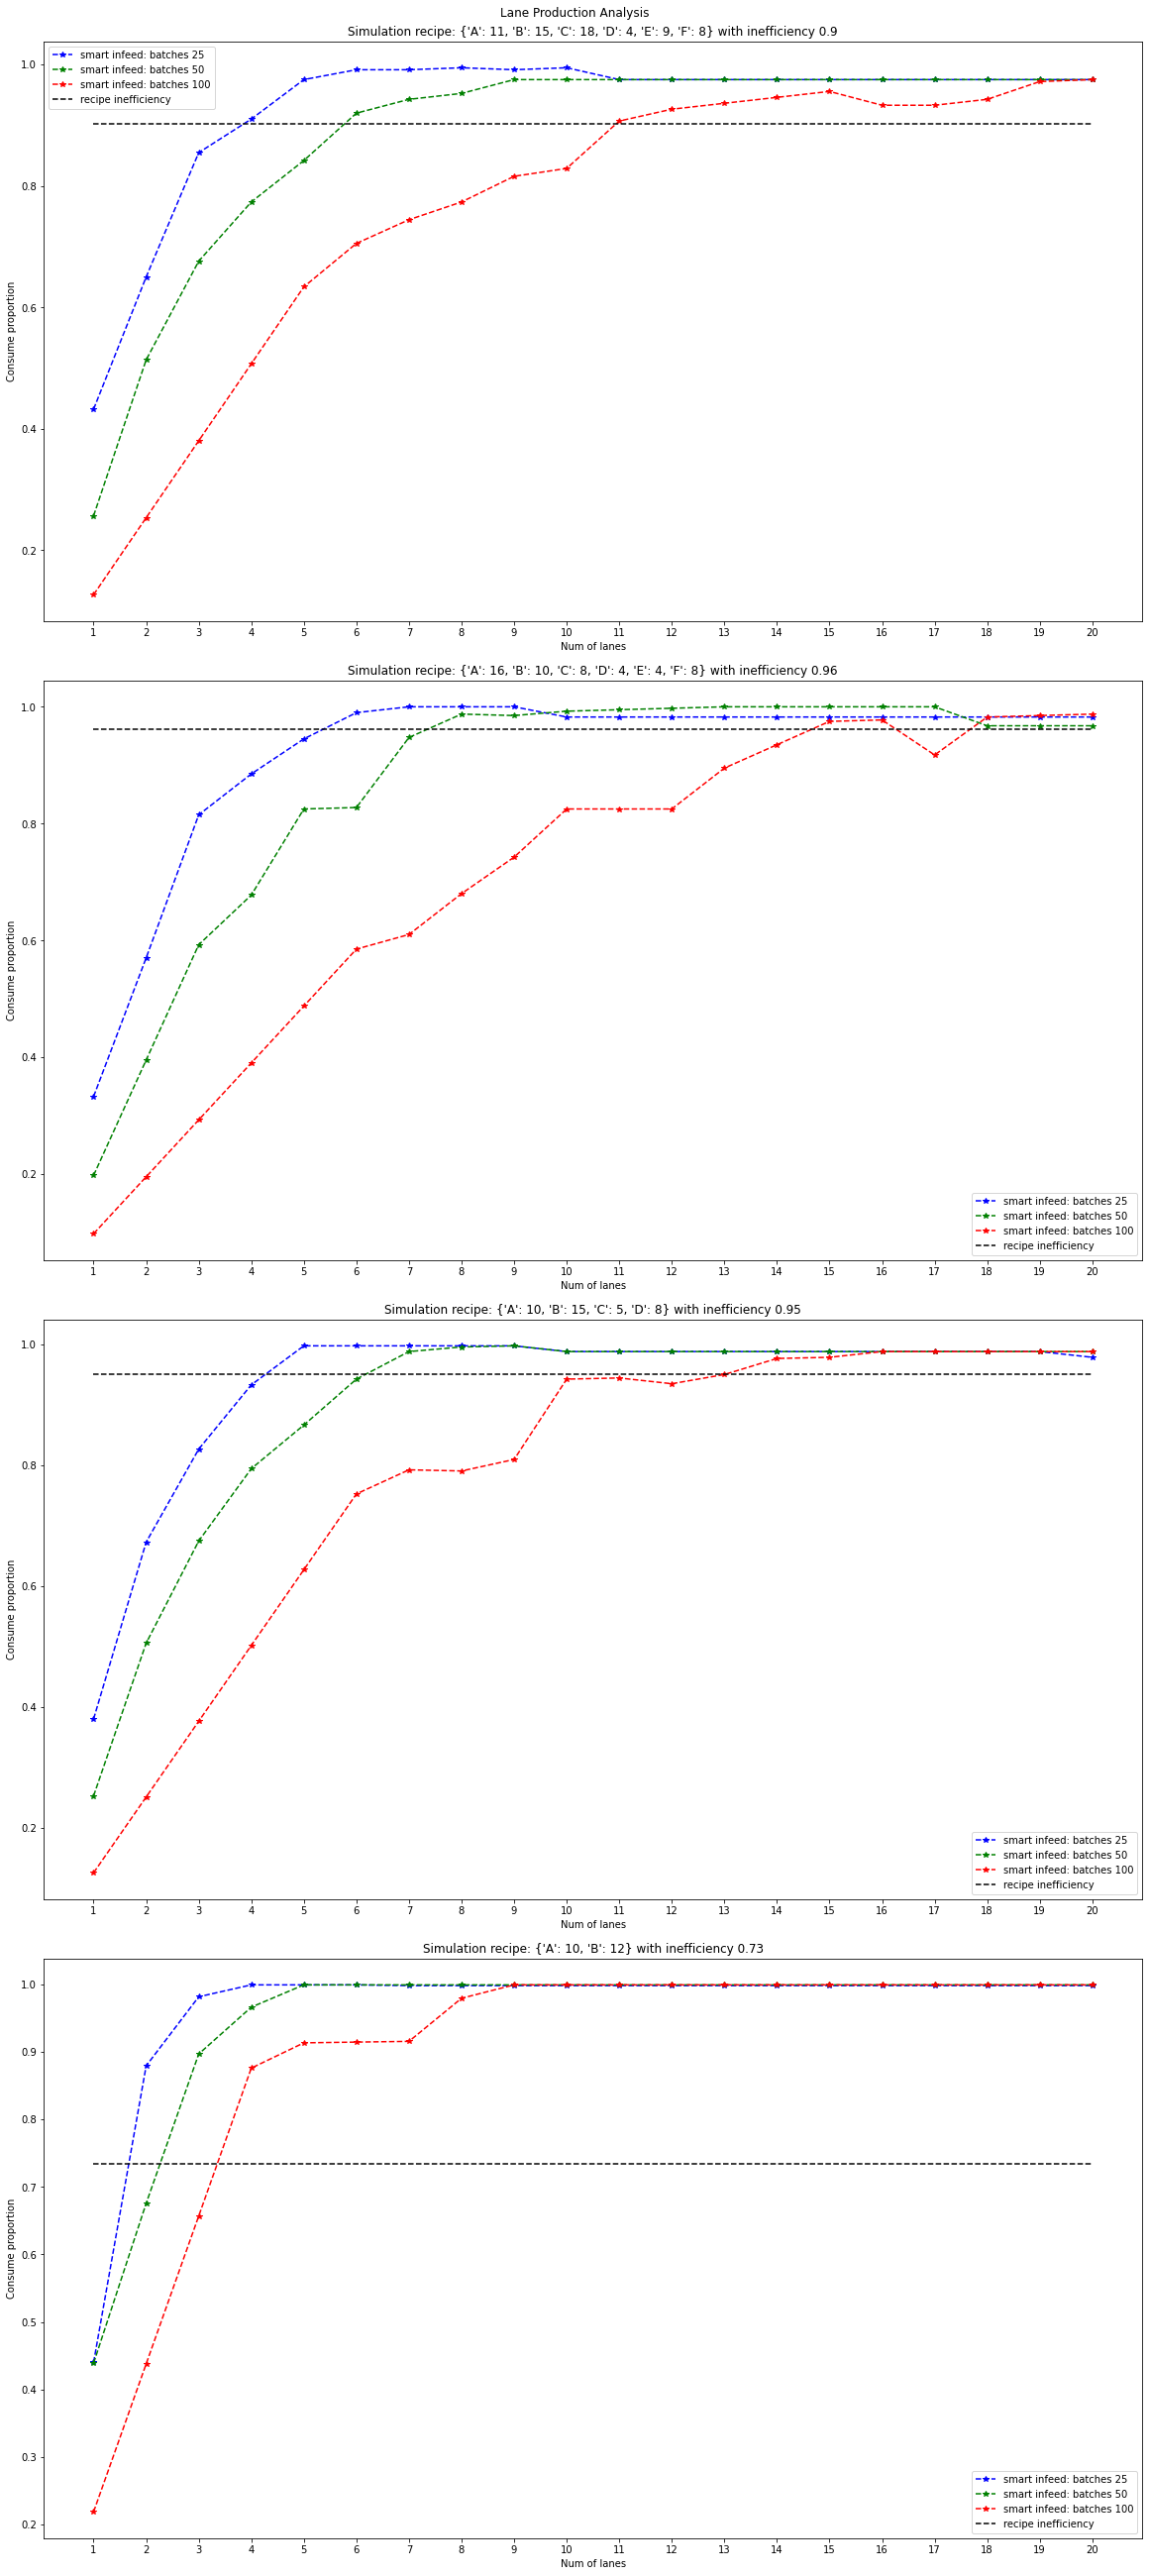

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, axs = plt.subplots(len(recipes), figsize=(16, 9*len(recipes)), constrained_layout=True)

fig.suptitle("Lane Production Analysis")

for recipe_index, recipe in enumerate(recipes):
    
    color_index = 0
    xx = list(range(1, 21)) #+ list(range(20, 100, 10))
    for (index, sequence_type, batch_size) in sequences.keys():
        
        if recipe_index != index:
            continue
            
        color = list(mcolors.BASE_COLORS.items())[color_index][0]
        color_index += 1
        # normal
#         yy = get_the_ys(xx, sequence_type, recipe_index, recipe, batch_size)
#         axs[recipe_index].plot(xx, yy, f"-{color}", marker="*", label=f"sequencial infeed: {sequence_type} {batch_size}")
        
        # smart
        if sequence_type != "random":
            yy = get_the_ys(xx, "smart", recipe_index, recipe, batch_size)
            axs[recipe_index].plot(xx, yy, f"--{color}", marker="*", label=f"smart infeed: batches {batch_size}")

    zz = np.ones(len(xx)) * (1-recipe_inefficiency(recipe))
    axs[recipe_index].plot(xx, zz, f"--k", label=f"recipe inefficiency")
    axs[recipe_index].set_xticks(xx)
    axs[recipe_index].legend()
    axs[recipe_index].set_title(f"Simulation recipe: {recipe} with inefficiency {round(zz[0], 2)}")
    axs[recipe_index].set_xlabel("Num of lanes")
    axs[recipe_index].set_ylabel("Consume proportion")
plt.show()